## openrlhf reward algorithm


In [ ]:
import torch
def process_sequences(sequences: torch.Tensor, input_len, eos_token_id, pad_token_id):
        # Create initial attention mask by marking positions that are neither EOS nor padding tokens
        attention_mask = (sequences.ne(eos_token_id) & sequences.ne(pad_token_id)).to(dtype=torch.long)
        seq_length = attention_mask.size(1)

        # Find the position of the last valid token in each sequence
        eos_indices = seq_length - attention_mask.long().fliplr().argmax(dim=1, keepdim=True).clamp(min=1)

        # Handle cases where EOS tokens might appear in the middle of the prompt (for Llama3 and Qwen2 models)
        # Find the position of the first valid token in each sequence
        first_token_indices = attention_mask.long().argmax(dim=1, keepdim=True)
        # Create position mask
        mask = torch.arange(seq_length).unsqueeze(0).expand(sequences.size(0), -1).to(device=sequences.device)
        # Generate final attention mask, keeping only positions between first and last valid tokens
        attention_mask = (mask >= first_token_indices) & (mask <= eos_indices).to(dtype=torch.long)

        # In reinforcement learning, the state transition is represented as:
        # state_i (current token) + action_i (next token) -> state_i+1 (next token)
        # Generate state sequence from input_len-1 to second-to-last token
        state_seq = sequences[:, input_len - 1 : -1]
        # Generate action mask indicating valid action token positions
        action_mask = state_seq.ne(eos_token_id) & state_seq.ne(pad_token_id)
        action_mask[:, 0] = 1

        return sequences, attention_mask, action_mask

# Common parameters for tests
eos_token_id = 2
pad_token_id = 0
input_len = 1  # Example input length

# Test case with simple sequences
sequences = torch.tensor([
    [1, 3, 4, 2, 0, 0, 0],  # Sequence with EOS in middle
    [1, 3, 4, 5, 6, 7, 2],  # Full sequence with EOS at end
    [0, 0, 1, 3, 4, 2, 0]   # Sequence with padding at start
])

sequences, attention_mask, action_mask = process_sequences(sequences, input_len, eos_token_id, pad_token_id)
print("Processed Sequences:")
print(sequences)
print("Attention Mask:")
print(attention_mask)
print("Action Mask:")
print(action_mask)

Processed Sequences:
tensor([[1, 3, 4, 2, 0, 0, 0],
        [1, 3, 4, 5, 6, 7, 2],
        [0, 0, 1, 3, 4, 2, 0]])
Attention Mask:
tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 0]])
Action Mask:
tensor([[ True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True, False]])


In [12]:
from typing import Optional, Tuple, Union

def compute_reward(
    r: Union[torch.Tensor, float],
    kl_coef: float,
    kl: Union[torch.Tensor, list[torch.Tensor]],
    action_mask: Optional[torch.Tensor] = None,
    num_actions: Optional[Union[int, list[int]]] = None,
    reward_clip_range: Tuple[float, float] = None,
) -> Union[torch.Tensor, list[torch.Tensor]]:
    if kl_coef <= 0.0:
        kl_coef = 0.0

    if reward_clip_range:
        r = r.clamp(min=reward_clip_range[0], max=reward_clip_range[1])

    if action_mask is not None:
        kl_reward = -kl_coef * kl
        # The following code is equivalent to:

        # last_reward = torch.zeros_like(kl)
        # for i in range(last_reward.size(0)):
        #     for t in reversed(range(last_reward.size(1))):
        #         if action_mask[i][t] > 0.5:
        #             last_reward[i][t] = r[i]
        #             break
        #
        eos_indices = action_mask.size(1) - 1 - action_mask.long().fliplr().argmax(dim=1, keepdim=True)
        last_reward = torch.zeros_like(kl).scatter_(dim=1, index=eos_indices, src=r.unsqueeze(1).to(kl.dtype))

        reward = last_reward + kl_reward
    else:
        # TODO: write a more efficient version
        reward = []
        for i, (kl_seg, action_len) in enumerate(zip(kl, num_actions)):
            kl_reward = -kl_coef * kl_seg
            kl_reward[action_len - 1] += r[i]
            reward.append(kl_reward)

    return reward


kl_coef = 0.1  # Example KL coefficient
reward_clip_range = (-10.0, 10.0)  # Example clip range
    
# Test case with action mask
r = torch.tensor([5.0, 3.0, 7.0])  # Reward values
kl = torch.tensor([
    [0.2, 0.3, 0.1, 0.0],
    [0.4, 0.5, 0.0, 0.0],
    [0.1, 0.2, 0.3, 0.4]
])
action_mask = torch.tensor([
    [1, 1, 1, 0],  # Only first 3 actions are valid
    [1, 1, 0, 0],  # Only first 2 actions are valid
    [1, 1, 1, 1]   # All actions are valid
], dtype=torch.bool)


reward = compute_reward(r, kl_coef, kl, action_mask=action_mask, reward_clip_range=reward_clip_range)
print("Computed Reward:")   
print(reward)


Computed Reward:
tensor([[-0.0200, -0.0300,  4.9900,  0.0000],
        [-0.0400,  2.9500,  0.0000,  0.0000],
        [-0.0100, -0.0200, -0.0300,  6.9600]])


In [16]:
from typing import Optional, Tuple, Union
def get_advantages_and_returns(
    values: torch.Tensor,
    rewards: torch.Tensor,
    action_mask: torch.Tensor,
    gamma: float,
    lambd: float,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Function that computes advantages and returns from rewards and values.
    Calculated as in the original PPO paper: https://arxiv.org/abs/1707.06347
    Note that rewards may include a KL divergence loss term.

    Advantages looks like this:
    Adv1 =  R1 + γ * λ * R2     + γ^2 * λ^2 * R3       + ...
            - V1 + γ * (1 - λ) V2 + γ^2 * λ * (1 - λ) V3 + ...

    Returns looks like this:
    Ret1 =  R1 + γ * λ * R2     + γ^2 * λ^2 * R3       + ...
                + γ * (1 - λ) V2 + γ^2 * λ * (1 - λ) V3 + ...

    Input:
    - values: Tensor of shape (batch_size, response_size)
    - rewards: Tensor of shape (batch_size, response_size)

    Output:
    - advantages: Tensor of shape (batch_size, response_size)
    - returns: Tensor of shape (batch_size, response_size)
    """
    lastgaelam = 0
    advantages_reversed = []
    response_length = rewards.size(1)

    # Mask invalid responses
    if action_mask is not None:
        values = action_mask * values
        rewards = action_mask * rewards

    for t in reversed(range(response_length)):
        nextvalues = values[:, t + 1] if t < response_length - 1 else 0.0
        delta = rewards[:, t] + gamma * nextvalues - values[:, t]
        lastgaelam = delta + gamma * lambd * lastgaelam
        advantages_reversed.append(lastgaelam)
    advantages = torch.stack(advantages_reversed[::-1], dim=1)
    returns = advantages + values
    return advantages.detach(), returns

gamma = 0.8
lambd = 0.9

# 测试用例1: 简单序列，无mask
values = torch.tensor([[0.6, 0.4, 0.2, 0.5, 0.1, 0.3]])
rewards = torch.tensor([[-0.001, -0.002, -0.003, -0.01, -0.02, 0.57]])
action_mask = torch.tensor([[1, 1, 1, 1, 1, 1]], dtype=torch.long)

advantages, returns = get_advantages_and_returns(values, rewards, action_mask, gamma, lambd)

print("Advantages:", advantages)
print("Returns:", returns)

Advantages: tensor([[-0.4291, -0.2057,  0.0504, -0.2036,  0.3144,  0.2700]])
Returns: tensor([[0.1709, 0.1943, 0.2504, 0.2964, 0.4144, 0.5700]])


In [21]:
values = [0.6, 0.4, 0.2, 0.5, 0.1, 0.3]
rewards = [-0.001, -0.002, -0.003, -0.01, -0.02, 0.57]
gae = 0.0
gamma = 0.8
lambd = 0.9
for t in reversed(range(len(rewards))):  
    if t == len(rewards) - 1:
        next_value = 0.0
    else:
        next_value = values[t + 1]  
    delta = rewards[t] + gamma * next_value - values[t]
    gae = delta + gamma * lambd * gae
    print(f"t={t}, delta={delta}, gae={gae}")


t=5, delta=0.26999999999999996, gae=0.26999999999999996
t=4, delta=0.12, gae=0.3144
t=3, delta=-0.43, gae=-0.20363199999999995
t=2, delta=0.197, gae=0.050384960000000034
t=1, delta=-0.242, gae=-0.20572282879999998
t=0, delta=-0.2809999999999999, gae=-0.4291204367359999


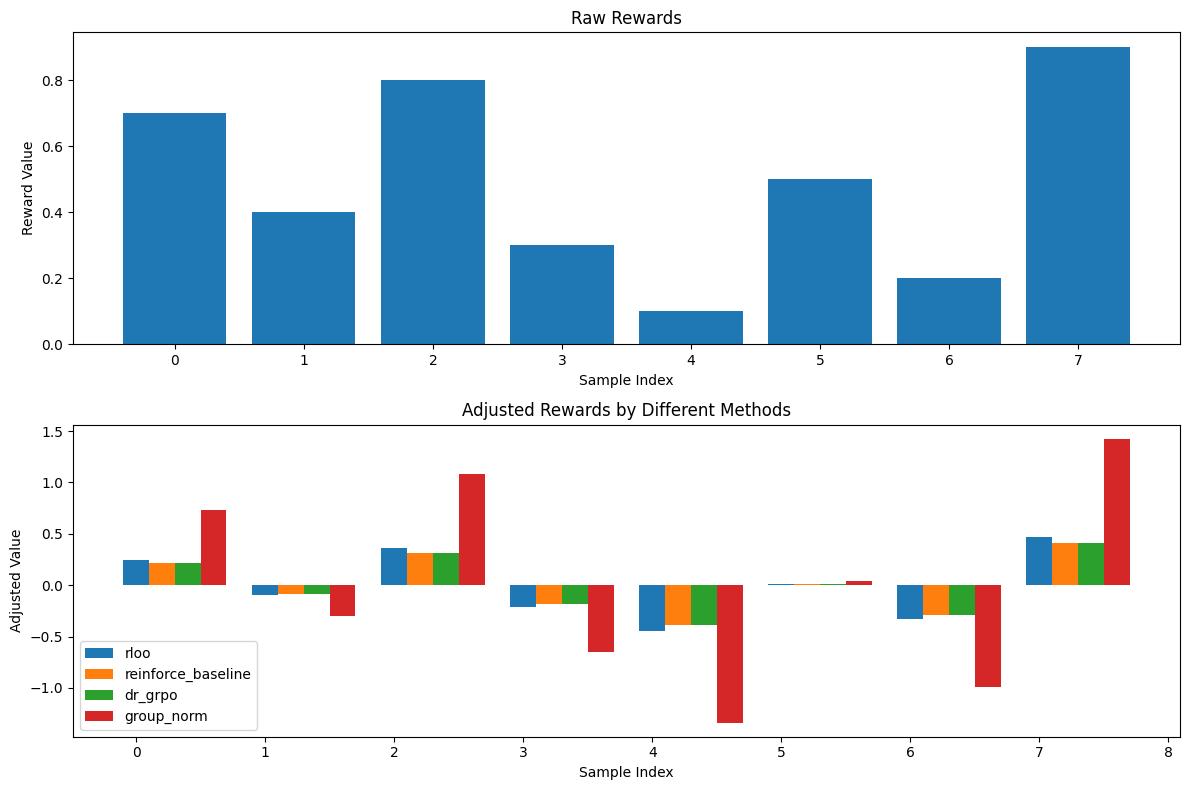


Method Comparison Statistics:
Method               Mean            Std             Range          
rloo                 -0.0000         0.3100          0.9143         
reinforce_baseline   -0.0000         0.2713          0.8000         
dr_grpo              -0.0000         0.2713          0.8000         
group_norm           -0.0000         0.9354          2.7585         
raw                  0.4875          0.2713          0.8000         


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# 模拟参数设置
n_prompts = 1
n_samples_per_prompt = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

# 转换为torch张量
rewards = torch.tensor([[0.7, 0.4, 0.8, 0.3, 0.1, 0.5, 0.2, 0.9]], dtype=torch.float32)

# 模拟experiences结构
experiences = [None] * (n_prompts * n_samples_per_prompt)

# 定义测试函数
def apply_estimator(estimator_type):
    if estimator_type == "rloo":
        rewards_tensor = rewards.clone().to(device)
        baseline = (rewards_tensor.sum(-1, keepdim=True) - rewards_tensor) / (n_samples_per_prompt - 1)
        adjusted = rewards_tensor - baseline
        return adjusted.cpu().flatten().numpy()
    elif estimator_type in ["reinforce_baseline", "dr_grpo"]:
        rewards_tensor = rewards.clone().to(device)
        adjusted = rewards_tensor - rewards_tensor.mean(-1, keepdim=True)
        return adjusted.cpu().flatten().numpy()
    elif estimator_type == "group_norm":
        rewards_tensor = rewards.clone().to(device)
        adjusted = (rewards_tensor - rewards_tensor.mean(-1, keepdim=True)) / (rewards_tensor.std(-1, keepdim=True) + 1e-9)
        return adjusted.cpu().flatten().numpy()

# 测试所有方法
methods = ["rloo", "reinforce_baseline", "dr_grpo", "group_norm"]
results = {method: apply_estimator(method) for method in methods}

# 添加原始奖励作为参考
results["raw"] = rewards.flatten().numpy()

# 可视化比较
plt.figure(figsize=(12, 8))

# 绘制原始奖励
plt.subplot(2, 1, 1)
plt.bar(range(len(results["raw"])), results["raw"])
plt.title("Raw Rewards")
plt.xlabel("Sample Index")
plt.ylabel("Reward Value")

# 绘制各种方法调整后的奖励
plt.subplot(2, 1, 2)
x = np.arange(len(results["raw"]))
width = 0.2
for i, method in enumerate(methods):
    plt.bar(x + i*width, results[method], width=width, label=method)
plt.title("Adjusted Rewards by Different Methods")
plt.xlabel("Sample Index")
plt.ylabel("Adjusted Value")
plt.legend()

plt.tight_layout()
plt.show()

# 打印统计信息
print("\nMethod Comparison Statistics:")
print("{:<20} {:<15} {:<15} {:<15}".format("Method", "Mean", "Std", "Range"))
for method, values in results.items():
    print("{:<20} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        method, np.mean(values), np.std(values), np.max(values) - np.min(values)))




In [14]:
rewards_tensor = rewards.clone().to(device)
baseline = (rewards_tensor.sum(-1, keepdim=True) - rewards_tensor) / (n_samples_per_prompt - 1)
adjusted = rewards_tensor - baseline

print("Original Rewards:", rewards.flatten().numpy())
print("Baseline:", baseline.cpu().flatten().numpy())
print("Adjusted Rewards (RLOO):", adjusted.cpu().to(device="cpu").chunk(len(experiences)))

Original Rewards: [0.7 0.4 0.8 0.3 0.1 0.5 0.2 0.9]
Baseline: [0.4571429  0.5        0.44285718 0.51428574 0.54285717 0.48571432
 0.5285715  0.42857146]
Adjusted Rewards (RLOO): (tensor([[ 0.2429, -0.1000,  0.3571, -0.2143, -0.4429,  0.0143, -0.3286,  0.4714]]),)


In [17]:
def get_cumulative_returns(
    rewards: torch.Tensor,
    action_mask: torch.Tensor,
    gamma: float,
):
    """
    Function that computes advantages and returns from rewards using REINFORCE.
    REINFORCE uses cumulative returns without the GAE (Generalized Advantage Estimation).

    Input:
    - rewards: Tensor of shape (batch_size, response_size)
    - action_mask: Tensor of shape (batch_size, response_size), binary mask
    - gamma: discount factor

    Output:
    - returns: Tensor of shape (batch_size, response_size)
    """
    response_length = rewards.size(1)
    returns = torch.zeros_like(rewards)
    cumulative_return = torch.zeros(rewards.size(0), device=rewards.device)

    # Mask invalid responses if action_mask is provided
    if action_mask is not None:
        rewards = action_mask * rewards

    # Calculate returns by accumulating discounted rewards
    for t in reversed(range(response_length)):
        cumulative_return = rewards[:, t] + gamma * cumulative_return
        returns[:, t] = cumulative_return

    return returns, cumulative_return

rewards = torch.tensor([[-0.001, -0.002, -0.003, -0.01, -0.02, 0.57]])
action_mask = torch.tensor([[1, 1, 1, 1, 1, 1]], dtype=torch.long)
gamma = 1.0

returns, cumulative_return = get_cumulative_returns(rewards, action_mask, gamma)
print("Returns (REINFORCE):", returns)
print("Cumulative Returns:", cumulative_return)


Returns (REINFORCE): tensor([[0.5340, 0.5350, 0.5370, 0.5400, 0.5500, 0.5700]])
Cumulative Returns: tensor([0.5340])
